## Overview of HuggingFace PEFT
在这个文档中，将介绍PEFT的概念，通过Prefix Tuning、Prompt Tuning和LoRA三种具有代表性的方法了解PEFT技术，最后介绍peft库的总体结构和框架设计。

### PEFT概述
随着预训练语言模型的规模越来越大，出现了两个关键问题：一是微调困难，消费级硬件不可能完成全量微调（Full Fine-Tuning），显存容量完全不够，即使可以训练，其时间开销也不可接受；二是存储代价太大，如果对于每个下游任务的微调都保存了完整模型，存储支出极为昂贵，因为每个微调模型都像原始模型的备份，空间开销是一样的。

针对这种情况，PEFT（Parameter-Efficient Fine-Tuning 参数高效微调）技术诞生，用以解决以上的问题。PEFT技术的核心思想是冻结预训练模型原本的参数，引入了一些外部的可训练参数，这些参数的规模远小于原始模型的参数规模，通过训练和保存这些外部参数完成微调，使得训练和存储的开销大大降低。使用时，需要将原始模型参数与外部参数合并然后使用，同一个模型可以进行不同的微调得到多个adapter，在使用时按需加载，非常灵活。而且随着PEFT技术发展，其微调性能甚至不弱于全量微调。

PEFT这种思路的产生是一系列研究和实验的结果，前序研究表明，大模型微调只需要训练其中很小一部分参数，就可以达到很好的效果。不同方法之间的本质差异就是如何引入外部参数。

PEFT技术的产生源于预训练语言模型的微调需求，但是随着发展，从LoRA技术开始，就已经不限于语言模型了，可以应用于任意模型。

在peft库的PeftType类中，枚举了目前版本支持的所有微调方法。

In [ ]:
class PeftType(str, enum.Enum):
    """Enum class for the different types of adapters in PEFT."""

    PROMPT_TUNING = "PROMPT_TUNING"
    MULTITASK_PROMPT_TUNING = "MULTITASK_PROMPT_TUNING"
    P_TUNING = "P_TUNING"
    PREFIX_TUNING = "PREFIX_TUNING"
    LORA = "LORA"
    ADALORA = "ADALORA"
    ADAPTION_PROMPT = "ADAPTION_PROMPT"
    IA3 = "IA3"
    LOHA = "LOHA"
    LOKR = "LOKR"
    OFT = "OFT"

### Prefix tuning
Prefix Tuning在模型输入前添加一个连续的且任务特定的向量序列，就是一个可训练的tensor，称之为前缀（prefix）。前缀被视为一系列“virtual tokens”，它被加入到tokens中，由不对应于真实tokens的自由参数组成，占据的token数量由自己定义。通过固定模型参数，只训练这些前缀完成微调。

Prefix Tuning的一个显著弊端，就是需要为prefix保留位置，这占据了本就有限的序列长度。

此外，直接训练prefix是不稳定的，因此需要加入一个两层的MLP进行重参数化，训练完成后，只保存前缀。
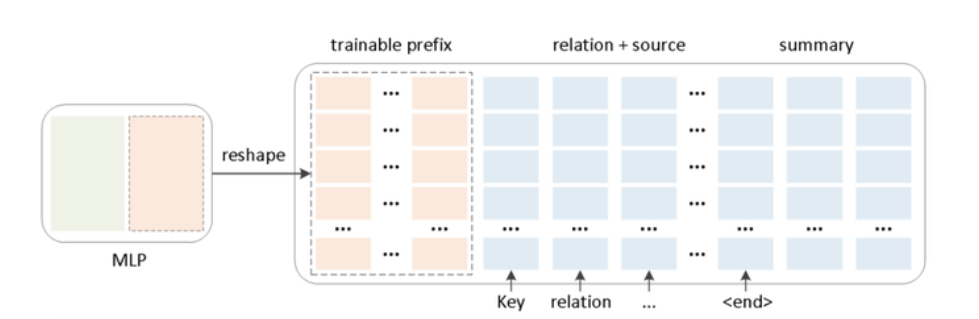

对于Transformer，prefix参数一般被添加到所有层的开头。
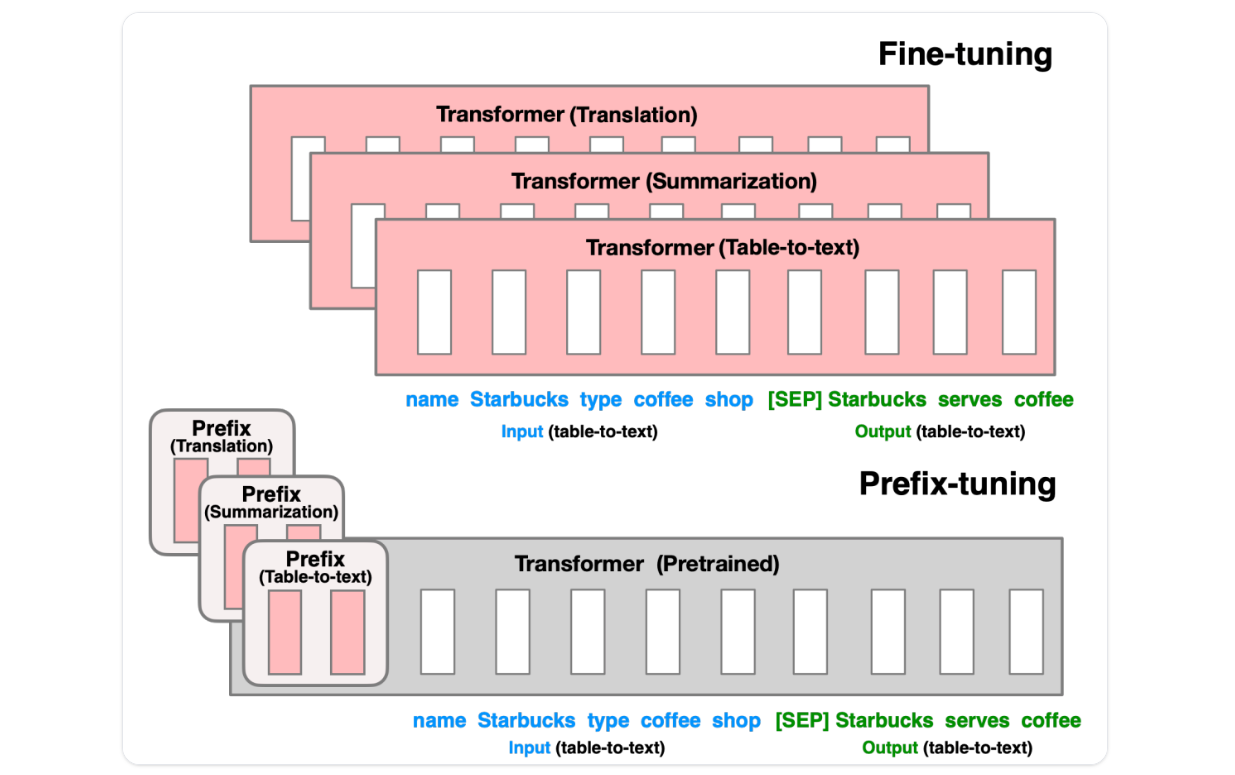

### Prompt tuning
Prompt Tuning可以看作是Prefix Tuning的简化版本，它给每个任务定义了自己的Prompt，Prompt是自己写的或者随机创建的，然后拼接到数据上作为输入，和prefix一样，prompt占据的token数量也是自己定义，token数量会决定额外的参数量，但只在输入层加入prompt tokens。

Prompt Tuning不需要加入MLP进行调整来解决难训练的问题，而且可以同时针对多个任务训练（peft库目前貌似不支持），弊端仍然是占据序列长度。
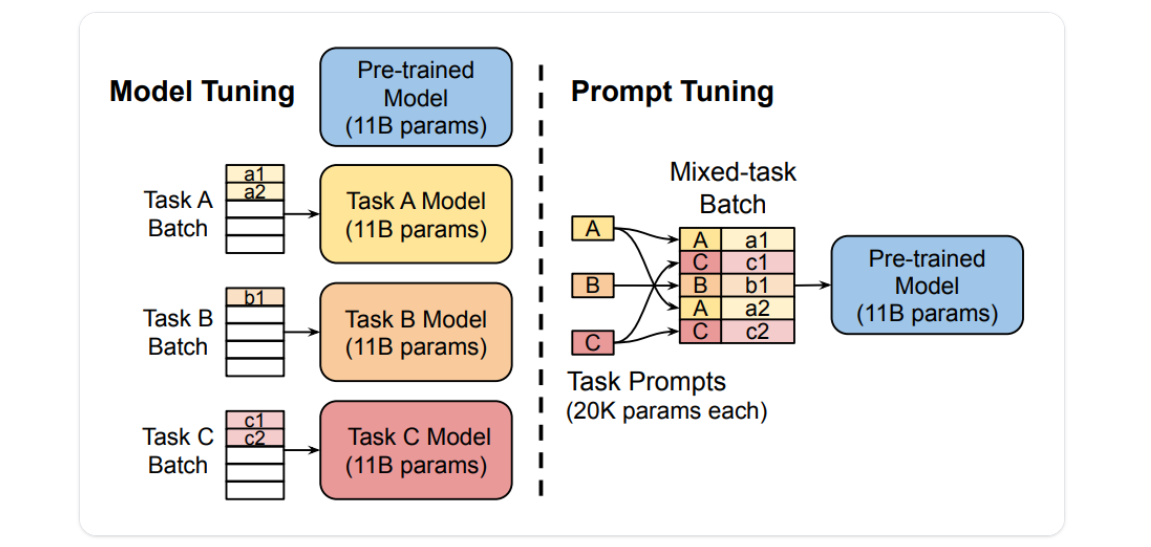

Prompt Tuning还提出了Prompt Ensembling方法，也就是在一个Batch里同时训练同一个任务的不同prompts（即采用多种不同方式询问同一个问题），这样相当于训练了不同模型。peft库目前貌似也不支持，没有找到相关代码。
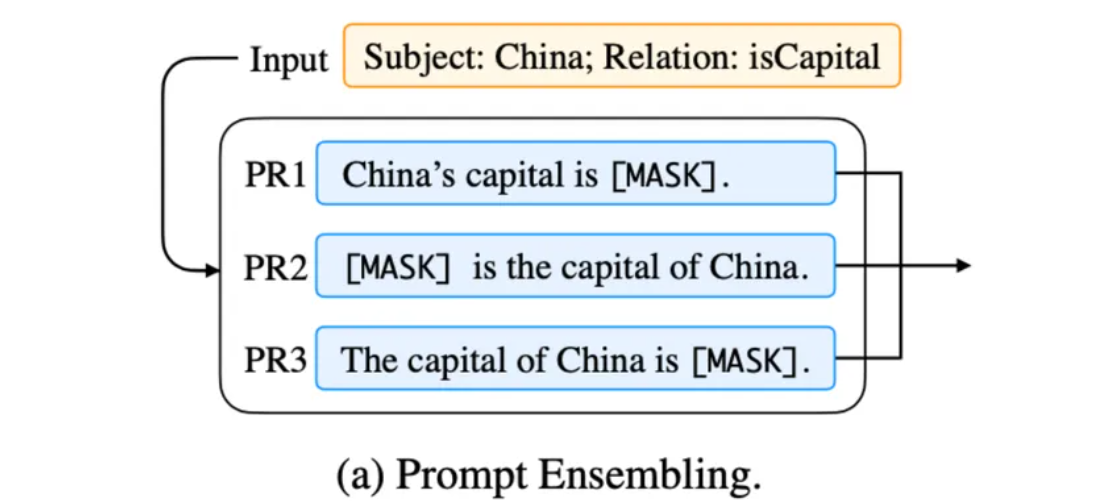

### LoRA
LoRA是对Adapt Tuning改进，Adapt Tuning是在模型中的某些层或者每一层加入Adapter结构，如下图所示
Adapter具有两个前馈子层，第一个前馈子层输入维度为d，输出维度降为m；第二个前馈子层输入维度为m，输出维度升为d。m远小于d，因此Adapter参数量更少。通过固定模型主体参数，只训练Adapters，完成微调。

这种做法不占用序列长度，但是弊端也很明显，引入的Adapter层会增加计算，产生推理延迟。
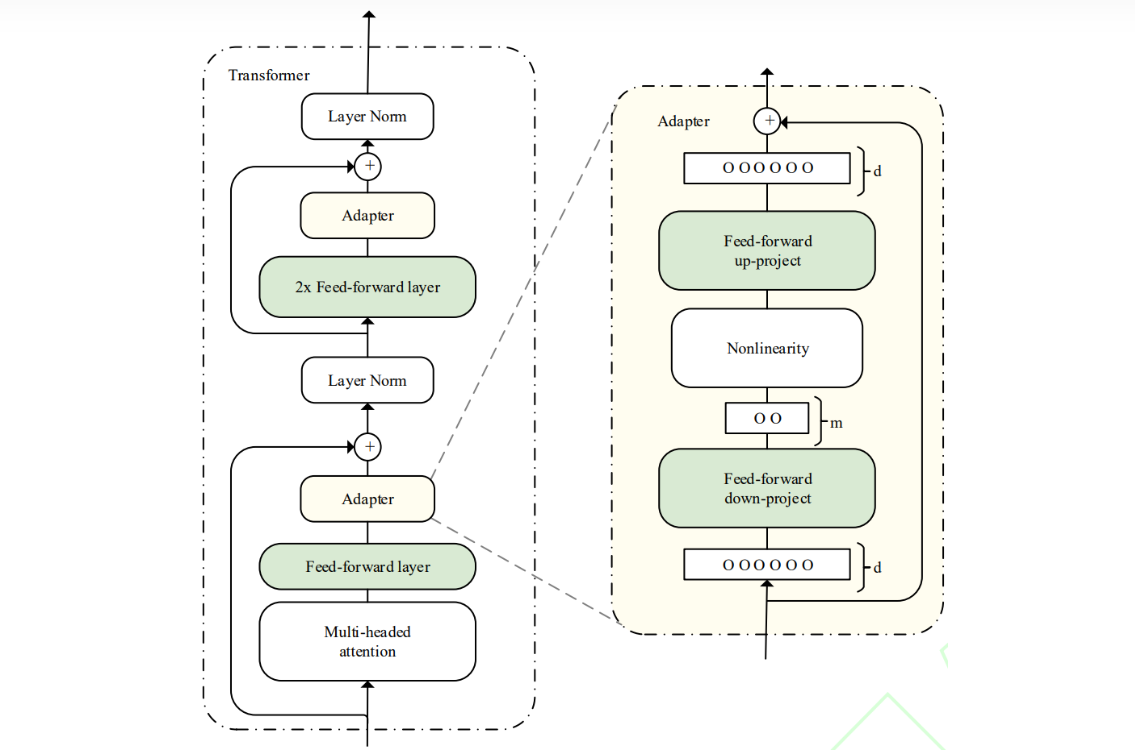

LoRA在以上基础上，使用秩分解矩阵进行训练，继承Adapter Tuning优点的同时，也没有推理延迟。
了解LoRA前，学习以下概念：

矩阵的秩：最大线性独立行数与最大线性独立列数中的最小值，矩阵通过初等变换化为最简后的非零行数和非零列数中的最小值。

本征秩(intrinsic rank)：Transformer等神经网络包含许多执行矩阵乘法的密集层，这些权重矩阵通常具有满秩。如果一个大模型是将数据映射到高维空间进行处理，这里假定在处理一个细分的小任务时，是不需要那么复杂的大模型的，可能只需要在某个子空间范围内就可以解决，那么也就不需要对全量参数进行优化了，我们可以定义当对某个子空间参数进行优化时，能够达到全量参数优化的性能的一定水平（如90%精度）时，那么这个子空间参数矩阵的秩就可以称为对应当前待解决问题的本征秩（intrinsic rank）。

如果说秩体现了信息量，那么本征秩就体现了执行一个任务时的有效信息量，任务越简单，本征秩就越小。预训练语言模型在微调时，通常都具有很小的本征秩，因此，可以用低秩矩阵代替原本的满秩矩阵，从而降低参数量，但是实现差不多的效果。

在LoRA中，用AB两个低秩更新矩阵来模拟权重矩阵W，r是可以自定义的参数，A是降维矩阵d×r，B是升维矩阵r×d，r远小于d，参数量从d×d减小到2×d×r。一般用高斯分布初始化A，用0初始化B，在训练时，W和BA是并行的，输入x分别经过矩阵W和BA然后合并，权重矩阵不更新，训练完成后（推理前），BA合并到W，得到新的权重矩阵。这种方式没有引入新结构，推理前只需要很小的代价完成矩阵合并，推理时没有额外的参数，也不需要额外的计算，因此不会产生推理延迟。

LoRA可以部署到任意执行权重矩阵乘法的layer，在Transformer中，LoRA矩阵一般应用于注意力模块的q、v矩阵。
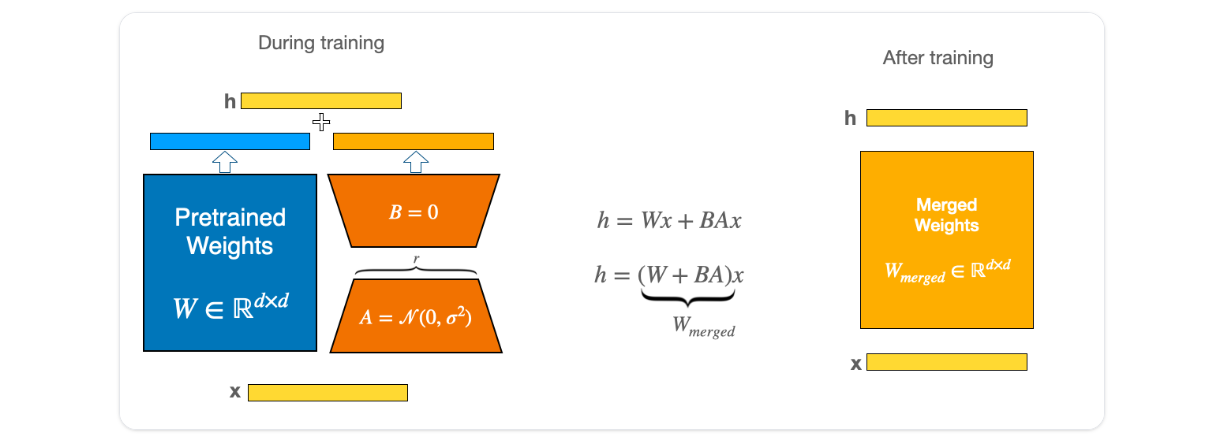

### PEFT框架
HuggingFace的peft库粗略而言，可以分成三部分：PeftConfig（peft模型配置）、PeftModel（peft模型生成）、Adapter（peft方法实现）。具体而言，可以分成五部分来介绍，下面将依次介绍各个部分的组成与其作用。

### - PEFT types
在这一部分中，通过PeftType和TaskType两个类，分别枚举出框架当前支持的所有peft方法和任务类型，在辅助开发者使用peft model的同时，也记录了peft库的开发进展。

In [ ]:
class PeftType(str, enum.Enum):
    """Enum class for the different types of adapters in PEFT."""
    
    PROMPT_TUNING = "PROMPT_TUNING"
    MULTITASK_PROMPT_TUNING = "MULTITASK_PROMPT_TUNING"
    P_TUNING = "P_TUNING"
    PREFIX_TUNING = "PREFIX_TUNING"
    LORA = "LORA"
    ADALORA = "ADALORA"
    ADAPTION_PROMPT = "ADAPTION_PROMPT"
    IA3 = "IA3"
    LOHA = "LOHA"
    LOKR = "LOKR"
    OFT = "OFT"

class TaskType(str, enum.Enum):
    """Enum class for the different types of tasks supported by PEFT."""

    SEQ_CLS = "SEQ_CLS"
    SEQ_2_SEQ_LM = "SEQ_2_SEQ_LM"
    CAUSAL_LM = "CAUSAL_LM"
    TOKEN_CLS = "TOKEN_CLS"
    QUESTION_ANS = "QUESTION_ANS"
    FEATURE_EXTRACTION = "FEATURE_EXTRACTION"

### - PEFT config
peft config是peft model的重要组成部分，框架在这一部分提供了基类，对于不同的peft方法，根据需要继承这些基类，创建方法对应的配置类。

下图展示了各个config类之间的关系
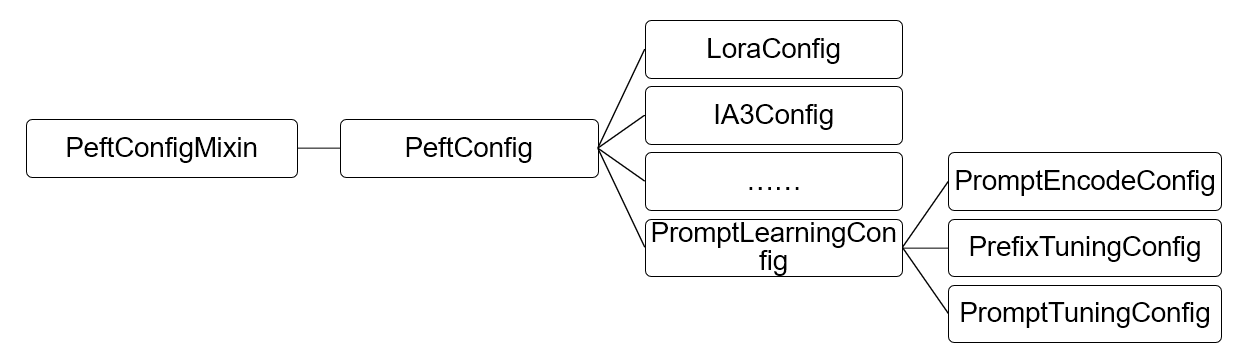

PeftConfigMixin类提供了peft_type参数和最基本的方法

In [ ]:
# 删减后的PeftConfigMixin
class PeftConfigMixin(PushToHubMixin):
    peft_type: Optional[PeftType] = field(default=None, metadata={"help": "The type of PEFT model."})
    auto_mapping: Optional[dict] = field(
        default=None, metadata={"help": "An auto mapping dict to help retrieve the base model class if needed."}
    )

    def to_dict(self) -> Dict:
        r"""
        Returns the configuration for your adapter model as a dictionary.
        """
        
    def save_pretrained(self, save_directory: str, **kwargs) -> None:
        r"""
        This method saves the configuration of your adapter model in a directory.

        Args:
            save_directory (`str`):
                The directory where the configuration will be saved.
            kwargs (additional keyword arguments, *optional*):
                Additional keyword arguments passed along to the [`~transformers.utils.PushToHubMixin.push_to_hub`]
                method.
        """

    @classmethod
    def from_pretrained(cls, pretrained_model_name_or_path: str, subfolder: Optional[str] = None, **kwargs):
        r"""
        This method loads the configuration of your adapter model from a directory.

        Args:
            pretrained_model_name_or_path (`str`):
                The directory or the Hub repository id where the configuration is saved.
            kwargs (additional keyword arguments, *optional*):
                Additional keyword arguments passed along to the child class initialization.
        """

    @classmethod
    def from_json_file(cls, path_json_file: str, **kwargs):
        r"""
        Loads a configuration file from a json file.

        Args:
            path_json_file (`str`):
                The path to the json file.
        """
    
    @property
    def is_prompt_learning(self) -> bool:
        r"""
        Utility method to check if the configuration is for prompt learning.
        """
        return False
    
    @property
    def is_adaption_prompt(self) -> bool:
        """Return True if this is an adaption prompt config."""
        return False

PeftConfig和PromptLearningConfig则主要对参数进行了拓展

In [ ]:
# 删减后的定义
class PeftConfig(PeftConfigMixin):
    """
    This is the base configuration class to store the configuration of a [`PeftModel`].

    Args:
        peft_type (Union[[`~peft.utils.config.PeftType`], `str`]): The type of Peft method to use.
        task_type (Union[[`~peft.utils.config.TaskType`], `str`]): The type of task to perform.
        inference_mode (`bool`, defaults to `False`): Whether to use the Peft model in inference mode.
    """
    base_model_name_or_path: Optional[str] = field(
        default=None, metadata={"help": "The name of the base model to use."}
    )
    revision: Optional[str] = field(default=None, metadata={"help": "The specific model version to use."})
    peft_type: Optional[Union[str, PeftType]] = field(default=None, metadata={"help": "Peft type"})
    task_type: Optional[Union[str, TaskType]] = field(default=None, metadata={"help": "Task type"})
    inference_mode: bool = field(default=False, metadata={"help": "Whether to use inference mode"})

class PromptLearningConfig(PeftConfig):
    """
    This is the base configuration class to store the configuration of [`PrefixTuning`], [`PromptEncoder`], or
    [`PromptTuning`].

    Args:
        num_virtual_tokens (`int`): The number of virtual tokens to use.
        token_dim (`int`): The hidden embedding dimension of the base transformer model.
        num_transformer_submodules (`int`): The number of transformer submodules in the base transformer model.
        num_attention_heads (`int`): The number of attention heads in the base transformer model.
        num_layers (`int`): The number of layers in the base transformer model.
    """
    num_virtual_tokens: int = field(default=None, metadata={"help": "Number of virtual tokens"})
    token_dim: int = field(
        default=None, metadata={"help": "The hidden embedding dimension of the base transformer model"}
    )
    num_transformer_submodules: Optional[int] = field(
        default=None, metadata={"help": "Number of transformer submodules"}
    )
    num_attention_heads: Optional[int] = field(default=None, metadata={"help": "Number of attention heads"})
    num_layers: Optional[int] = field(default=None, metadata={"help": "Number of transformer layers"})

    @property
    def is_prompt_learning(self) -> bool:
        r"""
        Utility method to check if the configuration is for prompt learning.
        """
        return True

### - PEFT model
获得一个peft model，需要完成配置，加载base model，然后根据配置调用相应配置的方法处理base model，PeftModel类就是用来完成处理这一过程的，在PeftModel类的初始化中，会根据配置中的peft_type按照相应方法对base model进行处理。由PeftModel派生出了TaskType中所有任务的PeftModelFor类。

In [ ]:
from .peft_model import (
    PeftModel,
    PeftModelForCausalLM,
    PeftModelForFeatureExtraction,
    PeftModelForQuestionAnswering,
    PeftModelForSeq2SeqLM,
    PeftModelForSequenceClassification,
    PeftModelForTokenClassification,
)

这一部分有三个重要的方法需要介绍。

PeftModelFor类继承了PeftModel类的from_pretrained()方法，所以加载peft model统一使用PeftModel.from_pretrained()，在这个方法中，会根据配置中的base model的任务类型，调用PeftModelFor类的初始化，生成peft model，然后使用load_adapter()根据配置加载adapter，只有base model的任务类型不在TaskType中时，才会直接调用PeftModel的初始化。

In [ ]:
class PeftModel(PushToHubMixin, torch.nn.Module):
    """
    Base model encompassing various Peft methods.

    Args:
        model ([`~transformers.PreTrainedModel`]): The base transformer model used for Peft.
        peft_config ([`PeftConfig`]): The configuration of the Peft model.
        adapter_name (`str`,  *optional*): The name of the adapter, defaults to `"default"`.

    **Attributes**:
        - **base_model** ([`torch.nn.Module`]) -- The base transformer model used for Peft.
        - **peft_config** ([`PeftConfig`]) -- The configuration of the Peft model.
        - **modules_to_save** (`list` of `str`) -- The list of sub-module names to save when
            saving the model.
        - **prompt_encoder** ([`PromptEncoder`]) -- The prompt encoder used for Peft if
            using [`PromptLearningConfig`].
        - **prompt_tokens** (`torch.Tensor`) -- The virtual prompt tokens used for Peft if
            using [`PromptLearningConfig`].
        - **transformer_backbone_name** (`str`) -- The name of the transformer
            backbone in the base model if using [`PromptLearningConfig`].
        - **word_embeddings** (`torch.nn.Embedding`) -- The word embeddings of the transformer backbone
            in the base model if using [`PromptLearningConfig`].
    """

    @classmethod
    def from_pretrained(
        cls,
        model: torch.nn.Module,
        model_id: Union[str, os.PathLike],
        adapter_name: str = "default",
        is_trainable: bool = False,
        config: Optional[PeftConfig] = None,
        **kwargs: Any,
    ) -> "PeftModel":
        r"""
        Instantiate a PEFT model from a pretrained model and loaded PEFT weights.

        Note that the passed `model` may be modified inplace.

        Args:
            model ([`torch.nn.Module`]):
                The model to be adapted. For 🤗 Transformers models, the model should be initialized with the
                [`~transformers.PreTrainedModel.from_pretrained`].
            model_id (`str` or `os.PathLike`):
                The name of the PEFT configuration to use. Can be either:
                    - A string, the `model id` of a PEFT configuration hosted inside a model repo on the Hugging Face
                      Hub.
                    - A path to a directory containing a PEFT configuration file saved using the `save_pretrained`
                      method (`./my_peft_config_directory/`).
            adapter_name (`str`, *optional*, defaults to `"default"`):
                The name of the adapter to be loaded. This is useful for loading multiple adapters.
            is_trainable (`bool`, *optional*, defaults to `False`):
                Whether the adapter should be trainable or not. If `False`, the adapter will be frozen and can only be
                used for inference.
            config ([`~peft.PeftConfig`], *optional*):
                The configuration object to use instead of an automatically loaded configuation. This configuration
                object is mutually exclusive with `model_id` and `kwargs`. This is useful when configuration is already
                loaded before calling `from_pretrained`.
            kwargs: (`optional`):
                Additional keyword arguments passed along to the specific PEFT configuration class.
        """
        from .mapping import MODEL_TYPE_TO_PEFT_MODEL_MAPPING, PEFT_TYPE_TO_CONFIG_MAPPING

        # load the config
        if config is None:
            config = PEFT_TYPE_TO_CONFIG_MAPPING[
                PeftConfig._get_peft_type(
                    model_id,
                    subfolder=kwargs.get("subfolder", None),
                    revision=kwargs.get("revision", None),
                    cache_dir=kwargs.get("cache_dir", None),
                    use_auth_token=kwargs.get("use_auth_token", None),
                    token=kwargs.get("token", None),
                )
            ].from_pretrained(model_id, **kwargs)
        elif isinstance(config, PeftConfig):
            config.inference_mode = not is_trainable
        else:
            raise ValueError(f"The input config must be a PeftConfig, got {config.__class__}")

        if (getattr(model, "hf_device_map", None) is not None) and len(
            set(model.hf_device_map.values()).intersection({"cpu", "disk"})
        ) > 0:
            remove_hook_from_submodules(model)

        if config.is_prompt_learning and is_trainable:
            raise ValueError("Cannot set a prompt learning adapter to trainable when loading pretrained adapter.")
        else:
            config.inference_mode = not is_trainable

        if config.task_type not in MODEL_TYPE_TO_PEFT_MODEL_MAPPING.keys():
            model = cls(model, config, adapter_name)
        else:
            model = MODEL_TYPE_TO_PEFT_MODEL_MAPPING[config.task_type](model, config, adapter_name)
        model.load_adapter(model_id, adapter_name, is_trainable=is_trainable, **kwargs)
        return model

创建一个peft model进行训练需要用到get_peft_model()方法，该方法和from_pretrained()类似，也是根据base model任务类型调用相应的PeftModel类初始化生成peft model，为用户简化了操作。

In [ ]:
def get_peft_model(
    model: PreTrainedModel, peft_config: PeftConfig, adapter_name: str = "default", mixed: bool = False
) -> PeftModel | PeftMixedModel:
    """
    Returns a Peft model object from a model and a config.

    Args:
        model ([`transformers.PreTrainedModel`]):
            Model to be wrapped.
        peft_config ([`PeftConfig`]):
            Configuration object containing the parameters of the Peft model.
        adapter_name (`str`, `optional`, defaults to `"default"`):
            The name of the adapter to be injected, if not provided, the default adapter name is used ("default").
        mixed (`bool`, `optional`, defaults to `False`):
            Whether to allow mixing different (compatible) adapter types.
    """
    model_config = getattr(model, "config", {"model_type": "custom"})
    if hasattr(model_config, "to_dict"):
        model_config = model_config.to_dict()

    peft_config.base_model_name_or_path = model.__dict__.get("name_or_path", None)

    if mixed:
        return PeftMixedModel(model, peft_config, adapter_name=adapter_name)

    if peft_config.task_type not in MODEL_TYPE_TO_PEFT_MODEL_MAPPING.keys() and not peft_config.is_prompt_learning:
        return PeftModel(model, peft_config, adapter_name=adapter_name)

    if peft_config.is_prompt_learning:
        peft_config = _prepare_prompt_learning_config(peft_config, model_config)
    return MODEL_TYPE_TO_PEFT_MODEL_MAPPING[peft_config.task_type](model, peft_config, adapter_name=adapter_name)

prepare_model_for_kbit_training()这个方法是为量化模型微调设计的，且只适用于Transformers中的模型。如果base model在from_pretrained()阶段被量化，则必须先通过该方法进行预处理，然后才能使用peft方法，具体的使用过程会在Tutorial文档中展示。

In [ ]:
def prepare_model_for_kbit_training(model, use_gradient_checkpointing=True, gradient_checkpointing_kwargs=None):
    r"""
    Note this method only works for `transformers` models.

    This method wraps the entire protocol for preparing a model before running a training. This includes:
        1- Cast the layernorm in fp32 2- making output embedding layer require grads 3- Add the upcasting of the lm
        head to fp32

    Args:
        model (`transformers.PreTrainedModel`):
            The loaded model from `transformers`
        use_gradient_checkpointing (`bool`, *optional*, defaults to `True`):
            If True, use gradient checkpointing to save memory at the expense of slower backward pass.
        gradient_checkpointing_kwargs (`dict`, *optional*, defaults to `None`):
            Keyword arguments to pass to the gradient checkpointing function, please refer to the documentation of
            `torch.utils.checkpoint.checkpoint` for more details about the arguments that you can pass to that method.
            Note this is only available in the latest transformers versions (> 4.34.1).
    """

### - Auto PEFT model
AutoPeftModel类用于快速、便捷地加载peft model，简化peft model使用过程。其用法与Transformers的AutoModel类几乎一致，并且就是依赖AutoModel类实现的，只需要模型路径一个参数就可以完成peft model加载的全过程。在Tutorial文档中，可以看到两种加载方法的实例。实现自动化的同时，该方法也失去了灵活性和通用性，必须使用AutoPeftModelFor类的from_pretrained()方法进行加载，因此只支持TaskType中的任务。对于不在TaskType中的任务，使用AutoPeftModel加载必须在config中存在mapping，指出base model类型和路径，不如直接使用另一种加载方式。

In [ ]:
# AutoPeftModel类
class AutoPeftModel(_BaseAutoPeftModel):
    _target_class = None
    _target_peft_class = PeftModel

class AutoPeftModelForCausalLM(_BaseAutoPeftModel):
    _target_class = AutoModelForCausalLM
    _target_peft_class = PeftModelForCausalLM

class AutoPeftModelForSeq2SeqLM(_BaseAutoPeftModel):
    _target_class = AutoModelForSeq2SeqLM
    _target_peft_class = PeftModelForSeq2SeqLM

class AutoPeftModelForSequenceClassification(_BaseAutoPeftModel):
    _target_class = AutoModelForSequenceClassification
    _target_peft_class = PeftModelForSequenceClassification

class AutoPeftModelForTokenClassification(_BaseAutoPeftModel):
    _target_class = AutoModelForTokenClassification
    _target_peft_class = PeftModelForTokenClassification

class AutoPeftModelForQuestionAnswering(_BaseAutoPeftModel):
    _target_class = AutoModelForQuestionAnswering
    _target_peft_class = PeftModelForQuestionAnswering

class AutoPeftModelForFeatureExtraction(_BaseAutoPeftModel):
    _target_class = AutoModel
    _target_peft_class = PeftModelForFeatureExtraction

### - Adapters
以上介绍的都是peft的基本框架，加入peft方法后才是完整的peft库。在peft库中，每种方法的产物都被称作adapter，但不能和Adapter tuning划等号。在peft库中实现一种微调方法，需要完成两部分：config类，框架已经给出了peft config的一些基类，根据方法需要，继承其中一些类，增加方法特有的参数即可；model类，这里是指该方法的具体实现，也就是构建要加入base model的模块。对于Prompt tuning这一类方法，框架没有提供基类，只能继承torch.nn.Module。而对于LoRA这一类（注入式）方法，框架提供了BaseTuner类，包含了一些通用的参数和方法，帮助实现peft方法。

In [ ]:
# 删减后的定义
class BaseTuner(nn.Module, ABC):
    r"""
    A base tuner model that provides the common methods and attributes for all tuners that are injectable into a
    torch.nn.Module

    For adding a new Tuner class, one needs to overwrite the following methods:

    - **_prepare_adapter_config**:
        A private method to eventually prepare the adapter config, for example in case the field `target_modules` is
        missing.
    - **_check_target_module_exists**:
        A helper private method to check if the passed module's key name matches any of the target modules in the
        adatper_config.
    - **_create_and_replace**:
        A private method to create and replace the target module with the adapter module.
    - **_check_target_module_exists**:
        A private helper method to check if the passed module's key name matches any of the target modules in the
        adatper_config.

    The easiest is to check what is done in the `peft.tuners.lora.LoraModel` class.

    Attributes:
        model (`torch.nn.Module`):
            The model to which the adapter tuner layers will be attached.
        forward (`Callable`):
            The forward method of the model.
        peft_config (`Union[`PeftConfig`, dict[str, PeftConfig]]`):
            The adapter configuration object, it should be a dictionary of `str` to `PeftConfig` objects. One can also
            pass a PeftConfig object and a new adapter will be created with the default name `adapter` or create a new
            dictionary with a key `adapter_name` and a value of that peft config.
        config (`dict[str, Any]`):
            The model configuration object, it should be a dictionary of `str` to `Any` objects.
    """

    def __init__(self, model, peft_config: Union[PeftConfig, dict[str, PeftConfig]], adapter_name: str) -> None:
        super().__init__()

    def inject_adapter(self, model: nn.Module, adapter_name: str):
        r"""
        Creates adapter layers and replaces the target modules with the adapter layers. This method is called under the
        hood by `peft.mapping.get_peft_model` if a non-prompt tuning adapter class is passed.

        The corresponding PEFT config is directly retrieved from the `peft_config` attribute of the BaseTuner class.

        Args:
            model (`nn.Module`):
                The model to be tuned.
            adapter_name (`str`):
                The adapter name.
        """

    def merge_adapter(self, adapter_names: Optional[list[str]] = None) -> None:
        """
        This method merges the adapter layers into the base model.

        Merging adapters can lead to a speed up of the forward pass. A copy of the adapter weights is still kept in
        memory, which is required to unmerge the adapters. In order to merge the adapter weights without keeping them
        in memory, please call `merge_and_unload`.

        Args:
            safe_merge (`bool`, *optional*):
                If `True`, the merge operation will be performed in a copy of the original weights and check for NaNs
                before merging the weights. This is useful if you want to check if the merge operation will produce
                NaNs. Defaults to `False`.
            adapter_names (`list[str]`, *optional*):
                The list of adapter names that should be merged. If `None`, all active adapters will be merged.
                Defaults to `None`.
        """

    def unmerge_adapter(self):
        """
        This method unmerges all merged adapter layers from the base model.
        """

class BaseTunerLayer(ABC):
    r"""
    A tuner layer mixin that provides the common methods and attributes for all tuners.

    Args:
        is_plugable (`bool`, *optional*):
            Whether the adapter layer can be plugged to any pytorch module
        ！！该参数目前已经删除，现在默认继承此类的方法就是可注入的！！
        active_adapters (Union[List[`str`], `str`], *optional*):
            The name of the active adapter.
    """

    active_adapter = None

    # All names of layers that may contain adapter (trainable) weights
    adapter_layer_names: tuple[str] = ()
        
    # All names of other parameters that may contain adapter-related parameters
    other_param_names: tuple[str] = ()

    # indicates whether all adapters should be disabled
    _disable_adapters: bool = False

    # the currently active adapter(s)
    _active_adapter: str | list[str] = "default"

    # List all merged adapters
    merged_adapters: list[str] = []

    def get_base_layer(self) -> nn.Module:
        """
        (Recursively) get the base_layer.

        This is necessary for the case that the tuner layer wraps another tuner layer.

        """

    def enable_adapters(self, enabled: bool) -> None:
        """Toggle the enabling and disabling of adapters

        Takes care of setting the requires_grad flag for the adapter weights.

        Args:
            enabled (bool): True to enable adapters, False to disable adapters
        """

    def set_adapter(self, adapter_names: str | list[str]) -> None:
        """Set the active adapter(s).

        Args:
            adapter_name (`str` or `List[str]`): Name of the adapter(s) to be activated.
        """

    def delete_adapter(self, adapter_name: str) -> None:
        """
        Delete an adapter from the layer

        This should be called on all adapter layers, or else we will get an inconsistent state.

        This method will also set a new active adapter if the deleted adapter was an active adapter. It is important
        that the new adapter is chosen in a deterministic way, so that the same adapter is chosen on all layers.

        Args:
            adapter_name (`str`): The name of the adapter to delete

        """

peft方法的实现补齐了框架的最后一块，源代码中的tuners文件夹下存放了PeftType中的各个peft方法的实现（称为Adapter或者Tuner）。

至此，peft库的框架结构介绍完毕。